# Dataset

In [1]:
import torchvision
from torchvision import transforms as T
from torch.utils.data import DataLoader, Dataset, random_split

transform = T.Compose(
    [T.ToTensor(),
     T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

full_set = torchvision.datasets.CIFAR10(root = '/data', train = True, download = True, transform = transform)

TRAIN_SIZE = int(len(full_set)*0.8)
VAL_SIZE = len(full_set) - TRAIN_SIZE

train_set, val_set = random_split(full_set, [TRAIN_SIZE, VAL_SIZE])

batch_size = 100

train_loader = DataLoader(train_set, batch_size = batch_size, shuffle = True)

val_loader = DataLoader(val_set, batch_size = batch_size, shuffle = True)

test_set = torchvision.datasets.CIFAR10(root = '/data', train = False, download = True, transform = transform)

test_loader = DataLoader(test_set, batch_size = batch_size, shuffle = True)


Files already downloaded and verified
Files already downloaded and verified


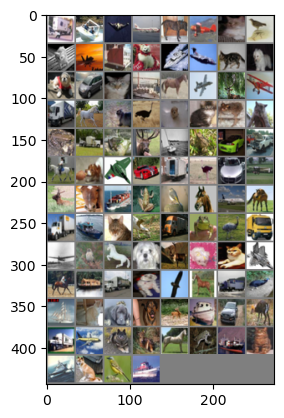

truck ship  plane plane dog   plane cat   bird  cat   plane truck dog   ship  plane cat   dog   dog   car   cat   ship  horse plane deer  plane truck horse cat   bird  dog   cat   frog  cat   frog  truck frog  deer  ship  frog  car   car   horse dog   plane car   truck bird  car   plane deer  horse ship  frog  bird  horse plane horse truck ship  cat   deer  truck frog  bird  truck plane bird  horse dog   deer  dog   cat   plane horse ship  truck dog   bird  horse truck bird  ship  cat   dog   dog   deer  ship  car   deer  truck plane dog   deer  horse frog  ship  cat   ship  dog   bird  ship 


In [2]:
import matplotlib.pyplot as plt
import numpy as np

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()



dataiter = iter(train_loader)
images, labels = next(dataiter)


imshow(torchvision.utils.make_grid(images))
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

# Deep Learning Model

In [3]:
import torch.nn as nn

class CNN_Model(nn.Module):
    def __init__(self, n_channels, n_classes):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(n_channels, 64, kernel_size = 3, stride = 1, padding = 1),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2,2),
            nn.Conv2d(64, 64, kernel_size = 3, stride = 1, padding = 1),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2,2),
            nn.Flatten(),
            nn.Linear(64 * 8 * 8, 128),
            nn.ReLU(),
            nn.Dropout(p = 0.2),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(p = 0.2),
            nn.Linear(64, n_classes),
            nn.Softmax(dim = 1)
            )
    def forward(self, x):
        return self.model(x)

# Training

In [4]:
import torch
import torch.optim as optim
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score
torch.cuda.empty_cache()

def train(model, loss_fn, lr, epochs, train_data, val_data, test_data):
    optimizer = optim.Adam(model.parameters(), lr =  lr)
    scaler  = torch.cuda.amp.GradScaler()
    lst_loss = []
    lst_accuracy = []
    mean_loss = 0
    mean_accuracy = 0
    lst_mean_loss = []
    lst_mean_accuracy = []
    val_lst_loss = []
    val_lst_accuracy = []
    val_mean_loss = 0
    val_mean_accuracy = 0
    val_lst_mean_loss = []
    val_lst_mean_accuracy = []
    test_lst_loss = []
    test_lst_accuracy = []
    test_mean_loss = 0
    test_mean_accuracy = 0
    test_lst_mean_loss = []
    test_lst_mean_accuracy = []
    for epoch in range(epochs):
        print("Epoch: ", epoch + 1)
        loop = tqdm(train_data)
        for mb, (x_input, y_output) in enumerate(loop, start = 1):
            model.train()
            x_input = x_input.to(device = device)
            y_output = y_output.to(device = device)
            with torch.cuda.amp.autocast():
                prediction = model(x_input)
                loss = loss_fn(prediction, y_output)
        
            optimizer.zero_grad()
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        
            loop.set_postfix(loss_function = loss.item())
        
        model.eval()
        lst_lost = []
        lst_accuracy = []
        for i, data in enumerate(train_data, 0):
            x_input, y_output = data
            x_input = x_input.to(device = device)
            y_output = y_output.to(device = device)
            with torch.no_grad():
                prediction = model(x_input)
                loss = loss_fn(prediction, y_output)
                lst_loss.append(loss.item())
                prediction = torch.argmax(prediction, dim = 1)
                prediction = prediction.cpu().numpy()
                y_output = y_output.cpu().numpy()
                accuracy = accuracy_score(y_output, prediction)
                lst_accuracy.append(accuracy)
        
        mean_loss = np.mean(lst_loss)
        lst_mean_loss.append(mean_loss)
        mean_accuracy = np.mean(lst_accuracy)
        lst_mean_accuracy.append(mean_accuracy)
        
        val_lst_lost = []
        val_lst_accuracy = []
        for i, data in enumerate(val_data, 0):
            x_input, y_output = data
            x_input = x_input.to(device = device)
            y_output = y_output.to(device = device)
            with torch.no_grad():
                prediction = model(x_input)
                loss = loss_fn(prediction, y_output)
                val_lst_loss.append(loss.item())
                prediction = torch.argmax(prediction, dim = 1)
                prediction = prediction.cpu().numpy()
                y_output = y_output.cpu().numpy()
                accuracy = accuracy_score(y_output, prediction)
                val_lst_accuracy.append(accuracy)
        
        val_mean_loss = np.mean(val_lst_loss)
        val_lst_mean_loss.append(val_mean_loss)
        val_mean_accuracy = np.mean(val_lst_accuracy)
        val_lst_mean_accuracy.append(val_mean_accuracy)
        
        test_lst_lost = []
        test_lst_accuracy = []
        for i, data in enumerate(test_data, 0):
            x_input, y_output = data
            x_input = x_input.to(device = device)
            y_output = y_output.to(device = device)
            with torch.no_grad():
                prediction = model(x_input)
                loss = loss_fn(prediction, y_output)
                test_lst_loss.append(loss.item())
                prediction = torch.argmax(prediction, dim = 1)
                prediction = prediction.cpu().numpy()
                y_output = y_output.cpu().numpy()
                accuracy = accuracy_score(y_output, prediction)
                test_lst_accuracy.append(accuracy)
        
        test_mean_loss = np.mean(test_lst_loss)
        test_lst_mean_loss.append(test_mean_loss)
        test_mean_accuracy = np.mean(test_lst_accuracy)
        test_lst_mean_accuracy.append(test_mean_accuracy)

    ax = sns.lineplot(x = range(len(lst_mean_loss)), y = lst_mean_loss, label = "Train")
    ax = sns.lineplot(x = range(len(val_lst_mean_loss)), y = val_lst_mean_loss, label = "Validation")
    ax = sns.lineplot(x = range(len(test_lst_mean_loss)), y = test_lst_mean_loss, label = "Test")
    
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.legend()
    plt.show()
    
    
    ax = sns.lineplot(x = range(len(lst_mean_accuracy)), y = lst_mean_accuracy, label = "Train")
    ax = sns.lineplot(x = range(len(val_lst_mean_accuracy)), y = val_lst_mean_accuracy, label = "Validation")
    ax = sns.lineplot(x = range(len(test_lst_mean_accuracy)), y = test_lst_mean_accuracy, label = "Test")
    
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.grid(True)
    plt.legend()
    plt.show()
    
    print("Train Loss: ", lst_mean_loss[-1])
    print("Validation Loss: ", val_lst_mean_loss[-1])
    print("Test Loss", test_lst_mean_loss[-1])
    print("Train Accuracy: ", lst_mean_accuracy[-1])
    print("Validation Accuracy: ", val_lst_mean_accuracy[-1])
    print("Test Accuracy", test_lst_mean_accuracy[-1])
    
    
    return model, lst_mean_loss[-1], val_lst_mean_loss[-1], test_lst_mean_loss[-1], lst_mean_accuracy[-1], val_lst_mean_accuracy[-1], test_lst_mean_accuracy[-1]

Epoch:  1


100%|████████████████████████████████████████████████████████████| 400/400 [00:08<00:00, 49.33it/s, loss_function=1.97]


Epoch:  2


100%|████████████████████████████████████████████████████████████| 400/400 [00:07<00:00, 51.77it/s, loss_function=1.94]


Epoch:  3


100%|████████████████████████████████████████████████████████████| 400/400 [00:07<00:00, 52.66it/s, loss_function=1.99]


Epoch:  4


100%|████████████████████████████████████████████████████████████| 400/400 [00:07<00:00, 52.93it/s, loss_function=1.87]


Epoch:  5


100%|████████████████████████████████████████████████████████████| 400/400 [00:07<00:00, 52.24it/s, loss_function=1.87]


Epoch:  6


100%|████████████████████████████████████████████████████████████| 400/400 [00:07<00:00, 51.91it/s, loss_function=1.88]


Epoch:  7


100%|█████████████████████████████████████████████████████████████| 400/400 [00:07<00:00, 51.22it/s, loss_function=1.9]


Epoch:  8


100%|█████████████████████████████████████████████████████████████| 400/400 [00:07<00:00, 52.02it/s, loss_function=1.8]


Epoch:  9


100%|████████████████████████████████████████████████████████████| 400/400 [00:07<00:00, 51.84it/s, loss_function=1.77]


Epoch:  10


100%|████████████████████████████████████████████████████████████| 400/400 [00:07<00:00, 52.26it/s, loss_function=1.78]


Epoch:  11


100%|████████████████████████████████████████████████████████████| 400/400 [00:07<00:00, 52.06it/s, loss_function=1.72]


Epoch:  12


100%|████████████████████████████████████████████████████████████| 400/400 [00:07<00:00, 52.18it/s, loss_function=1.81]


Epoch:  13


100%|████████████████████████████████████████████████████████████| 400/400 [00:07<00:00, 53.87it/s, loss_function=1.84]


Epoch:  14


100%|████████████████████████████████████████████████████████████| 400/400 [00:06<00:00, 57.39it/s, loss_function=1.74]


Epoch:  15


100%|████████████████████████████████████████████████████████████| 400/400 [00:07<00:00, 53.32it/s, loss_function=1.75]


Epoch:  16


100%|████████████████████████████████████████████████████████████| 400/400 [00:07<00:00, 51.53it/s, loss_function=1.78]


Epoch:  17


100%|████████████████████████████████████████████████████████████| 400/400 [00:07<00:00, 51.89it/s, loss_function=1.67]


Epoch:  18


100%|████████████████████████████████████████████████████████████| 400/400 [00:07<00:00, 52.35it/s, loss_function=1.76]


Epoch:  19


100%|████████████████████████████████████████████████████████████| 400/400 [00:07<00:00, 51.62it/s, loss_function=1.79]


Epoch:  20


100%|████████████████████████████████████████████████████████████| 400/400 [00:07<00:00, 52.24it/s, loss_function=1.74]


Epoch:  21


100%|████████████████████████████████████████████████████████████| 400/400 [00:07<00:00, 52.32it/s, loss_function=1.68]


Epoch:  22


100%|█████████████████████████████████████████████████████████████| 400/400 [00:07<00:00, 52.39it/s, loss_function=1.7]


Epoch:  23


100%|████████████████████████████████████████████████████████████| 400/400 [00:07<00:00, 52.03it/s, loss_function=1.74]


Epoch:  24


100%|████████████████████████████████████████████████████████████| 400/400 [00:07<00:00, 53.12it/s, loss_function=1.79]


Epoch:  25


100%|████████████████████████████████████████████████████████████| 400/400 [00:07<00:00, 52.61it/s, loss_function=1.69]


Epoch:  26


100%|████████████████████████████████████████████████████████████| 400/400 [00:07<00:00, 52.15it/s, loss_function=1.71]


Epoch:  27


100%|████████████████████████████████████████████████████████████| 400/400 [00:07<00:00, 52.62it/s, loss_function=1.66]


Epoch:  28


100%|████████████████████████████████████████████████████████████| 400/400 [00:07<00:00, 52.45it/s, loss_function=1.74]


Epoch:  29


100%|████████████████████████████████████████████████████████████| 400/400 [00:07<00:00, 52.43it/s, loss_function=1.68]


Epoch:  30


100%|████████████████████████████████████████████████████████████| 400/400 [00:07<00:00, 52.65it/s, loss_function=1.65]


Epoch:  31


100%|████████████████████████████████████████████████████████████| 400/400 [00:07<00:00, 53.66it/s, loss_function=1.66]


Epoch:  32


100%|████████████████████████████████████████████████████████████| 400/400 [00:07<00:00, 52.68it/s, loss_function=1.65]


Epoch:  33


100%|████████████████████████████████████████████████████████████| 400/400 [00:07<00:00, 52.64it/s, loss_function=1.68]


Epoch:  34


100%|████████████████████████████████████████████████████████████| 400/400 [00:07<00:00, 52.64it/s, loss_function=1.66]


Epoch:  35


100%|████████████████████████████████████████████████████████████| 400/400 [00:07<00:00, 52.64it/s, loss_function=1.65]


Epoch:  36


100%|████████████████████████████████████████████████████████████| 400/400 [00:07<00:00, 52.79it/s, loss_function=1.59]


Epoch:  37


100%|████████████████████████████████████████████████████████████| 400/400 [00:07<00:00, 52.95it/s, loss_function=1.61]


Epoch:  38


100%|████████████████████████████████████████████████████████████| 400/400 [00:07<00:00, 55.91it/s, loss_function=1.69]


Epoch:  39


100%|█████████████████████████████████████████████████████████████| 400/400 [00:07<00:00, 51.72it/s, loss_function=1.6]


Epoch:  40


100%|████████████████████████████████████████████████████████████| 400/400 [00:07<00:00, 52.00it/s, loss_function=1.61]


Epoch:  41


100%|████████████████████████████████████████████████████████████| 400/400 [00:07<00:00, 52.48it/s, loss_function=1.68]


Epoch:  42


100%|████████████████████████████████████████████████████████████| 400/400 [00:07<00:00, 52.48it/s, loss_function=1.63]


Epoch:  43


100%|████████████████████████████████████████████████████████████| 400/400 [00:07<00:00, 52.49it/s, loss_function=1.66]


Epoch:  44


100%|████████████████████████████████████████████████████████████| 400/400 [00:07<00:00, 52.13it/s, loss_function=1.64]


Epoch:  45


100%|████████████████████████████████████████████████████████████| 400/400 [00:07<00:00, 51.98it/s, loss_function=1.71]


Epoch:  46


100%|████████████████████████████████████████████████████████████| 400/400 [00:07<00:00, 52.08it/s, loss_function=1.63]


Epoch:  47


100%|█████████████████████████████████████████████████████████████| 400/400 [00:07<00:00, 52.40it/s, loss_function=1.6]


Epoch:  48


100%|████████████████████████████████████████████████████████████| 400/400 [00:07<00:00, 51.77it/s, loss_function=1.58]


Epoch:  49


100%|████████████████████████████████████████████████████████████| 400/400 [00:07<00:00, 51.89it/s, loss_function=1.61]


Epoch:  50


100%|████████████████████████████████████████████████████████████| 400/400 [00:07<00:00, 51.82it/s, loss_function=1.61]


Epoch:  51


100%|████████████████████████████████████████████████████████████| 400/400 [00:07<00:00, 52.52it/s, loss_function=1.61]


Epoch:  52


100%|████████████████████████████████████████████████████████████| 400/400 [00:07<00:00, 55.68it/s, loss_function=1.56]


Epoch:  53


100%|████████████████████████████████████████████████████████████| 400/400 [00:07<00:00, 54.43it/s, loss_function=1.59]


Epoch:  54


100%|████████████████████████████████████████████████████████████| 400/400 [00:07<00:00, 52.33it/s, loss_function=1.61]


Epoch:  55


100%|████████████████████████████████████████████████████████████| 400/400 [00:07<00:00, 52.33it/s, loss_function=1.66]


Epoch:  56


100%|████████████████████████████████████████████████████████████| 400/400 [00:07<00:00, 52.25it/s, loss_function=1.59]


Epoch:  57


100%|████████████████████████████████████████████████████████████| 400/400 [00:07<00:00, 52.46it/s, loss_function=1.55]


Epoch:  58


100%|████████████████████████████████████████████████████████████| 400/400 [00:07<00:00, 52.03it/s, loss_function=1.59]


Epoch:  59


100%|████████████████████████████████████████████████████████████| 400/400 [00:07<00:00, 51.90it/s, loss_function=1.57]


Epoch:  60


100%|████████████████████████████████████████████████████████████| 400/400 [00:07<00:00, 52.24it/s, loss_function=1.68]


Epoch:  61


100%|█████████████████████████████████████████████████████████████| 400/400 [00:07<00:00, 51.98it/s, loss_function=1.6]


Epoch:  62


100%|████████████████████████████████████████████████████████████| 400/400 [00:07<00:00, 52.24it/s, loss_function=1.65]


Epoch:  63


100%|█████████████████████████████████████████████████████████████| 400/400 [00:07<00:00, 52.39it/s, loss_function=1.6]


Epoch:  64


100%|████████████████████████████████████████████████████████████| 400/400 [00:07<00:00, 52.12it/s, loss_function=1.58]


Epoch:  65


100%|████████████████████████████████████████████████████████████| 400/400 [00:07<00:00, 52.57it/s, loss_function=1.56]


Epoch:  66


100%|█████████████████████████████████████████████████████████████| 400/400 [00:07<00:00, 52.59it/s, loss_function=1.6]


Epoch:  67


100%|████████████████████████████████████████████████████████████| 400/400 [00:07<00:00, 52.56it/s, loss_function=1.59]


Epoch:  68


100%|████████████████████████████████████████████████████████████| 400/400 [00:07<00:00, 52.36it/s, loss_function=1.61]


Epoch:  69


100%|████████████████████████████████████████████████████████████| 400/400 [00:07<00:00, 52.22it/s, loss_function=1.61]


Epoch:  70


100%|████████████████████████████████████████████████████████████| 400/400 [00:07<00:00, 53.84it/s, loss_function=1.57]


Epoch:  71


100%|████████████████████████████████████████████████████████████| 400/400 [00:07<00:00, 51.93it/s, loss_function=1.52]


Epoch:  72


100%|████████████████████████████████████████████████████████████| 400/400 [00:07<00:00, 51.73it/s, loss_function=1.57]


Epoch:  73


100%|████████████████████████████████████████████████████████████| 400/400 [00:07<00:00, 52.31it/s, loss_function=1.53]


Epoch:  74


100%|████████████████████████████████████████████████████████████| 400/400 [00:07<00:00, 52.41it/s, loss_function=1.54]


Epoch:  75


100%|████████████████████████████████████████████████████████████| 400/400 [00:07<00:00, 52.49it/s, loss_function=1.54]


Epoch:  76


100%|████████████████████████████████████████████████████████████| 400/400 [00:07<00:00, 52.31it/s, loss_function=1.62]


Epoch:  77


100%|████████████████████████████████████████████████████████████| 400/400 [00:07<00:00, 51.83it/s, loss_function=1.54]


Epoch:  78


100%|████████████████████████████████████████████████████████████| 400/400 [00:07<00:00, 52.13it/s, loss_function=1.54]


Epoch:  79


100%|████████████████████████████████████████████████████████████| 400/400 [00:07<00:00, 52.49it/s, loss_function=1.59]


Epoch:  80


100%|████████████████████████████████████████████████████████████| 400/400 [00:07<00:00, 53.73it/s, loss_function=1.58]


Epoch:  81


100%|████████████████████████████████████████████████████████████| 400/400 [00:07<00:00, 52.16it/s, loss_function=1.57]


Epoch:  82


100%|████████████████████████████████████████████████████████████| 400/400 [00:07<00:00, 52.65it/s, loss_function=1.59]


Epoch:  83


100%|████████████████████████████████████████████████████████████| 400/400 [00:07<00:00, 51.86it/s, loss_function=1.59]


Epoch:  84


100%|████████████████████████████████████████████████████████████| 400/400 [00:07<00:00, 54.97it/s, loss_function=1.53]


Epoch:  85


100%|████████████████████████████████████████████████████████████| 400/400 [00:07<00:00, 51.94it/s, loss_function=1.59]


Epoch:  86


100%|████████████████████████████████████████████████████████████| 400/400 [00:07<00:00, 52.46it/s, loss_function=1.51]


Epoch:  87


100%|████████████████████████████████████████████████████████████| 400/400 [00:07<00:00, 51.65it/s, loss_function=1.55]


Epoch:  88


100%|█████████████████████████████████████████████████████████████| 400/400 [00:07<00:00, 51.30it/s, loss_function=1.6]


Epoch:  89


100%|█████████████████████████████████████████████████████████████| 400/400 [00:07<00:00, 51.74it/s, loss_function=1.5]


Epoch:  90


100%|████████████████████████████████████████████████████████████| 400/400 [00:07<00:00, 51.17it/s, loss_function=1.55]


Epoch:  91


100%|████████████████████████████████████████████████████████████| 400/400 [00:07<00:00, 51.82it/s, loss_function=1.56]


Epoch:  92


100%|████████████████████████████████████████████████████████████| 400/400 [00:07<00:00, 51.82it/s, loss_function=1.54]


Epoch:  93


100%|████████████████████████████████████████████████████████████| 400/400 [00:07<00:00, 51.33it/s, loss_function=1.52]


Epoch:  94


100%|████████████████████████████████████████████████████████████| 400/400 [00:07<00:00, 52.29it/s, loss_function=1.58]


Epoch:  95


100%|████████████████████████████████████████████████████████████| 400/400 [00:07<00:00, 50.23it/s, loss_function=1.53]


Epoch:  96


100%|████████████████████████████████████████████████████████████| 400/400 [00:07<00:00, 51.26it/s, loss_function=1.53]


Epoch:  97


100%|████████████████████████████████████████████████████████████| 400/400 [00:07<00:00, 50.35it/s, loss_function=1.53]


Epoch:  98


100%|████████████████████████████████████████████████████████████| 400/400 [00:07<00:00, 50.55it/s, loss_function=1.53]


Epoch:  99


100%|████████████████████████████████████████████████████████████| 400/400 [00:07<00:00, 50.71it/s, loss_function=1.53]


Epoch:  100


100%|████████████████████████████████████████████████████████████| 400/400 [00:07<00:00, 50.35it/s, loss_function=1.58]


Epoch:  101


100%|████████████████████████████████████████████████████████████| 400/400 [00:07<00:00, 50.86it/s, loss_function=1.55]


Epoch:  102


100%|████████████████████████████████████████████████████████████| 400/400 [00:07<00:00, 50.90it/s, loss_function=1.57]


Epoch:  103


100%|████████████████████████████████████████████████████████████| 400/400 [00:08<00:00, 49.89it/s, loss_function=1.53]


Epoch:  104


100%|████████████████████████████████████████████████████████████| 400/400 [00:07<00:00, 50.18it/s, loss_function=1.57]


Epoch:  105


100%|████████████████████████████████████████████████████████████| 400/400 [00:07<00:00, 50.61it/s, loss_function=1.58]


Epoch:  106


100%|████████████████████████████████████████████████████████████| 400/400 [00:07<00:00, 50.01it/s, loss_function=1.55]


Epoch:  107


100%|████████████████████████████████████████████████████████████| 400/400 [00:07<00:00, 50.18it/s, loss_function=1.52]


Epoch:  108


100%|████████████████████████████████████████████████████████████| 400/400 [00:07<00:00, 50.13it/s, loss_function=1.51]


Epoch:  109


100%|████████████████████████████████████████████████████████████| 400/400 [00:08<00:00, 49.44it/s, loss_function=1.58]


Epoch:  110


100%|████████████████████████████████████████████████████████████| 400/400 [00:07<00:00, 50.23it/s, loss_function=1.53]


Epoch:  111


100%|████████████████████████████████████████████████████████████| 400/400 [00:08<00:00, 49.95it/s, loss_function=1.51]


Epoch:  112


100%|█████████████████████████████████████████████████████████████| 400/400 [00:07<00:00, 50.57it/s, loss_function=1.5]


Epoch:  113


100%|████████████████████████████████████████████████████████████| 400/400 [00:07<00:00, 50.46it/s, loss_function=1.49]


Epoch:  114


100%|████████████████████████████████████████████████████████████| 400/400 [00:07<00:00, 50.69it/s, loss_function=1.55]


Epoch:  115


100%|████████████████████████████████████████████████████████████| 400/400 [00:07<00:00, 50.29it/s, loss_function=1.57]


Epoch:  116


100%|████████████████████████████████████████████████████████████| 400/400 [00:07<00:00, 50.20it/s, loss_function=1.51]


Epoch:  117


100%|████████████████████████████████████████████████████████████| 400/400 [00:07<00:00, 50.36it/s, loss_function=1.57]


Epoch:  118


100%|████████████████████████████████████████████████████████████| 400/400 [00:07<00:00, 50.37it/s, loss_function=1.58]


Epoch:  119


100%|████████████████████████████████████████████████████████████| 400/400 [00:07<00:00, 50.54it/s, loss_function=1.51]


Epoch:  120


100%|█████████████████████████████████████████████████████████████| 400/400 [00:07<00:00, 50.56it/s, loss_function=1.6]


Epoch:  121


100%|████████████████████████████████████████████████████████████| 400/400 [00:07<00:00, 50.02it/s, loss_function=1.51]


Epoch:  122


100%|████████████████████████████████████████████████████████████| 400/400 [00:07<00:00, 50.10it/s, loss_function=1.55]


Epoch:  123


100%|████████████████████████████████████████████████████████████| 400/400 [00:07<00:00, 50.66it/s, loss_function=1.51]


Epoch:  124


100%|████████████████████████████████████████████████████████████| 400/400 [00:07<00:00, 51.93it/s, loss_function=1.53]


Epoch:  125


100%|████████████████████████████████████████████████████████████| 400/400 [00:07<00:00, 52.00it/s, loss_function=1.52]


Epoch:  126


100%|████████████████████████████████████████████████████████████| 400/400 [00:07<00:00, 51.88it/s, loss_function=1.51]


Epoch:  127


100%|████████████████████████████████████████████████████████████| 400/400 [00:07<00:00, 51.25it/s, loss_function=1.49]


Epoch:  128


100%|████████████████████████████████████████████████████████████| 400/400 [00:07<00:00, 51.13it/s, loss_function=1.53]


Epoch:  129


100%|████████████████████████████████████████████████████████████| 400/400 [00:07<00:00, 51.73it/s, loss_function=1.52]


Epoch:  130


100%|████████████████████████████████████████████████████████████| 400/400 [00:07<00:00, 51.53it/s, loss_function=1.49]


Epoch:  131


100%|█████████████████████████████████████████████████████████████| 400/400 [00:07<00:00, 50.84it/s, loss_function=1.5]


Epoch:  132


100%|████████████████████████████████████████████████████████████| 400/400 [00:07<00:00, 50.14it/s, loss_function=1.53]


Epoch:  133


100%|████████████████████████████████████████████████████████████| 400/400 [00:07<00:00, 50.24it/s, loss_function=1.52]


Epoch:  134


100%|████████████████████████████████████████████████████████████| 400/400 [00:08<00:00, 49.88it/s, loss_function=1.52]


Epoch:  135


100%|████████████████████████████████████████████████████████████| 400/400 [00:07<00:00, 50.54it/s, loss_function=1.54]


Epoch:  136


100%|████████████████████████████████████████████████████████████| 400/400 [00:07<00:00, 50.22it/s, loss_function=1.54]


Epoch:  137


100%|████████████████████████████████████████████████████████████| 400/400 [00:07<00:00, 50.40it/s, loss_function=1.51]


Epoch:  138


100%|████████████████████████████████████████████████████████████| 400/400 [00:07<00:00, 50.42it/s, loss_function=1.52]


Epoch:  139


100%|████████████████████████████████████████████████████████████| 400/400 [00:07<00:00, 50.25it/s, loss_function=1.55]


Epoch:  140


100%|████████████████████████████████████████████████████████████| 400/400 [00:07<00:00, 50.52it/s, loss_function=1.54]


Epoch:  141


100%|████████████████████████████████████████████████████████████| 400/400 [00:07<00:00, 50.12it/s, loss_function=1.53]


Epoch:  142


100%|████████████████████████████████████████████████████████████| 400/400 [00:07<00:00, 50.35it/s, loss_function=1.54]


Epoch:  143


100%|████████████████████████████████████████████████████████████| 400/400 [00:07<00:00, 50.07it/s, loss_function=1.53]


Epoch:  144


100%|████████████████████████████████████████████████████████████| 400/400 [00:07<00:00, 50.24it/s, loss_function=1.55]


Epoch:  145


100%|████████████████████████████████████████████████████████████| 400/400 [00:07<00:00, 50.39it/s, loss_function=1.51]


Epoch:  146


100%|████████████████████████████████████████████████████████████| 400/400 [00:07<00:00, 51.29it/s, loss_function=1.56]


Epoch:  147


100%|████████████████████████████████████████████████████████████| 400/400 [00:07<00:00, 50.32it/s, loss_function=1.58]


Epoch:  148


100%|█████████████████████████████████████████████████████████████| 400/400 [00:08<00:00, 49.94it/s, loss_function=1.5]


Epoch:  149


100%|████████████████████████████████████████████████████████████| 400/400 [00:07<00:00, 50.56it/s, loss_function=1.49]


Epoch:  150


100%|████████████████████████████████████████████████████████████| 400/400 [00:07<00:00, 50.32it/s, loss_function=1.56]


Epoch:  151


100%|████████████████████████████████████████████████████████████| 400/400 [00:07<00:00, 50.15it/s, loss_function=1.55]


Epoch:  152


100%|████████████████████████████████████████████████████████████| 400/400 [00:07<00:00, 50.13it/s, loss_function=1.53]


Epoch:  153


100%|████████████████████████████████████████████████████████████| 400/400 [00:07<00:00, 50.72it/s, loss_function=1.49]


Epoch:  154


100%|████████████████████████████████████████████████████████████| 400/400 [00:07<00:00, 50.49it/s, loss_function=1.54]


Epoch:  155


100%|████████████████████████████████████████████████████████████| 400/400 [00:07<00:00, 50.64it/s, loss_function=1.52]


Epoch:  156


100%|█████████████████████████████████████████████████████████████| 400/400 [00:07<00:00, 50.18it/s, loss_function=1.5]


Epoch:  157


100%|████████████████████████████████████████████████████████████| 400/400 [00:07<00:00, 50.27it/s, loss_function=1.51]


Epoch:  158


100%|████████████████████████████████████████████████████████████| 400/400 [00:07<00:00, 50.38it/s, loss_function=1.52]


Epoch:  159


100%|████████████████████████████████████████████████████████████| 400/400 [00:07<00:00, 51.01it/s, loss_function=1.52]


Epoch:  160


100%|████████████████████████████████████████████████████████████| 400/400 [00:07<00:00, 50.21it/s, loss_function=1.51]


Epoch:  161


100%|████████████████████████████████████████████████████████████| 400/400 [00:07<00:00, 51.62it/s, loss_function=1.53]


Epoch:  162


100%|████████████████████████████████████████████████████████████| 400/400 [00:07<00:00, 50.40it/s, loss_function=1.51]


Epoch:  163


100%|████████████████████████████████████████████████████████████| 400/400 [00:07<00:00, 50.11it/s, loss_function=1.53]


Epoch:  164


100%|████████████████████████████████████████████████████████████| 400/400 [00:07<00:00, 50.09it/s, loss_function=1.51]


Epoch:  165


100%|████████████████████████████████████████████████████████████| 400/400 [00:08<00:00, 49.90it/s, loss_function=1.58]


Epoch:  166


100%|█████████████████████████████████████████████████████████████| 400/400 [00:07<00:00, 50.04it/s, loss_function=1.5]


Epoch:  167


100%|████████████████████████████████████████████████████████████| 400/400 [00:08<00:00, 49.67it/s, loss_function=1.53]


Epoch:  168


100%|████████████████████████████████████████████████████████████| 400/400 [00:07<00:00, 50.65it/s, loss_function=1.54]


Epoch:  169


100%|█████████████████████████████████████████████████████████████| 400/400 [00:07<00:00, 50.36it/s, loss_function=1.5]


Epoch:  170


100%|████████████████████████████████████████████████████████████| 400/400 [00:07<00:00, 50.32it/s, loss_function=1.52]


Epoch:  171


100%|████████████████████████████████████████████████████████████| 400/400 [00:07<00:00, 50.39it/s, loss_function=1.49]


Epoch:  172


100%|█████████████████████████████████████████████████████████████| 400/400 [00:07<00:00, 50.37it/s, loss_function=1.5]


Epoch:  173


100%|████████████████████████████████████████████████████████████| 400/400 [00:07<00:00, 50.11it/s, loss_function=1.56]


Epoch:  174


100%|████████████████████████████████████████████████████████████| 400/400 [00:07<00:00, 50.24it/s, loss_function=1.48]


Epoch:  175


100%|████████████████████████████████████████████████████████████| 400/400 [00:07<00:00, 50.07it/s, loss_function=1.49]


Epoch:  176


100%|████████████████████████████████████████████████████████████| 400/400 [00:07<00:00, 50.02it/s, loss_function=1.48]


Epoch:  177


100%|████████████████████████████████████████████████████████████| 400/400 [00:07<00:00, 50.47it/s, loss_function=1.55]


Epoch:  178


100%|████████████████████████████████████████████████████████████| 400/400 [00:07<00:00, 50.32it/s, loss_function=1.52]


Epoch:  179


100%|████████████████████████████████████████████████████████████| 400/400 [00:07<00:00, 50.41it/s, loss_function=1.54]


Epoch:  180


100%|████████████████████████████████████████████████████████████| 400/400 [00:07<00:00, 50.04it/s, loss_function=1.49]


Epoch:  181


100%|████████████████████████████████████████████████████████████| 400/400 [00:07<00:00, 50.32it/s, loss_function=1.52]


Epoch:  182


100%|████████████████████████████████████████████████████████████| 400/400 [00:08<00:00, 49.99it/s, loss_function=1.53]


Epoch:  183


100%|████████████████████████████████████████████████████████████| 400/400 [00:07<00:00, 50.47it/s, loss_function=1.52]


Epoch:  184


100%|████████████████████████████████████████████████████████████| 400/400 [00:07<00:00, 50.49it/s, loss_function=1.51]


Epoch:  185


100%|████████████████████████████████████████████████████████████| 400/400 [00:07<00:00, 50.33it/s, loss_function=1.48]


Epoch:  186


100%|████████████████████████████████████████████████████████████| 400/400 [00:07<00:00, 50.67it/s, loss_function=1.52]


Epoch:  187


100%|████████████████████████████████████████████████████████████| 400/400 [00:07<00:00, 50.49it/s, loss_function=1.52]


Epoch:  188


100%|████████████████████████████████████████████████████████████| 400/400 [00:07<00:00, 50.07it/s, loss_function=1.55]


Epoch:  189


100%|████████████████████████████████████████████████████████████| 400/400 [00:07<00:00, 50.22it/s, loss_function=1.56]


Epoch:  190


100%|████████████████████████████████████████████████████████████| 400/400 [00:08<00:00, 49.25it/s, loss_function=1.52]


Epoch:  191


100%|████████████████████████████████████████████████████████████| 400/400 [00:07<00:00, 50.20it/s, loss_function=1.48]


Epoch:  192


100%|████████████████████████████████████████████████████████████| 400/400 [00:08<00:00, 50.00it/s, loss_function=1.52]


Epoch:  193


100%|████████████████████████████████████████████████████████████| 400/400 [00:08<00:00, 49.95it/s, loss_function=1.49]


Epoch:  194


100%|█████████████████████████████████████████████████████████████| 400/400 [00:07<00:00, 50.36it/s, loss_function=1.5]


Epoch:  195


100%|████████████████████████████████████████████████████████████| 400/400 [00:07<00:00, 50.14it/s, loss_function=1.46]


Epoch:  196


100%|████████████████████████████████████████████████████████████| 400/400 [00:07<00:00, 50.75it/s, loss_function=1.51]


Epoch:  197


100%|████████████████████████████████████████████████████████████| 400/400 [00:07<00:00, 50.35it/s, loss_function=1.49]


Epoch:  198


100%|████████████████████████████████████████████████████████████| 400/400 [00:08<00:00, 49.61it/s, loss_function=1.53]


Epoch:  199


100%|████████████████████████████████████████████████████████████| 400/400 [00:07<00:00, 50.20it/s, loss_function=1.49]


Epoch:  200


100%|████████████████████████████████████████████████████████████| 400/400 [00:07<00:00, 50.27it/s, loss_function=1.51]


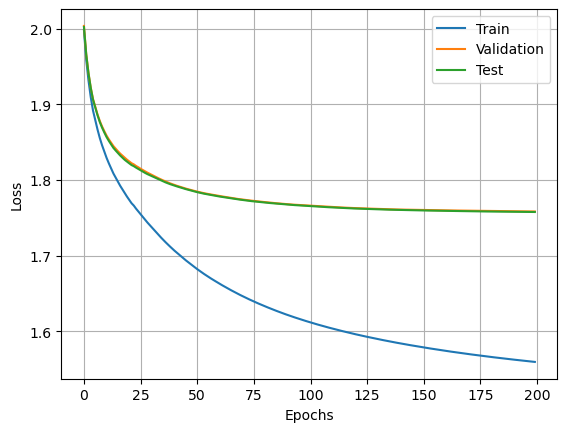

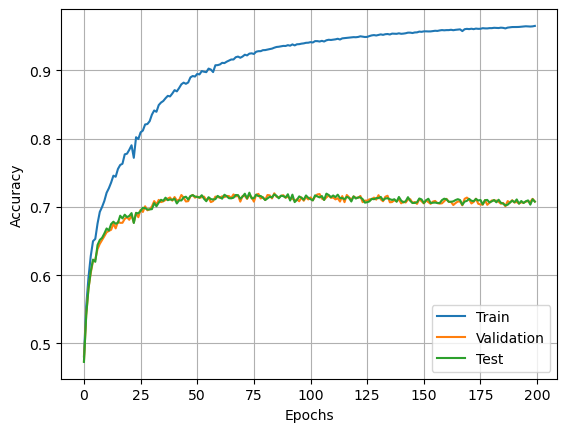

Train Loss:  1.5593439218327403
Validation Loss:  1.7582755281925202
Test Loss 1.7576082064449787
Train Accuracy:  0.9649500000000001
Validation Accuracy:  0.7078
Test Accuracy 0.7077


In [5]:
loss_fn = nn.CrossEntropyLoss()
lr = 1e-4
epochs = 200
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
cnn_model, train_loss, val_loss, test_loss, train_accuracy, val_accuracy, test_accuracy = train(CNN_Model(3, len(classes)).to(device), loss_fn, lr, epochs, train_loader, val_loader, test_loader)

# Make prediction

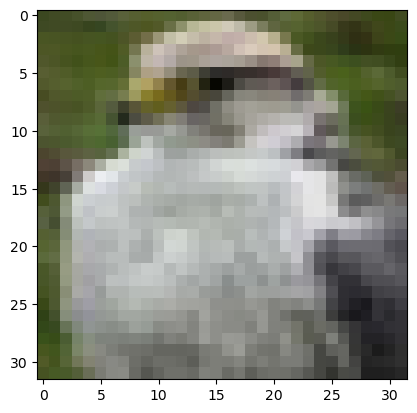

Target:  bird
Prediction:  bird
Accuracy:  1.0
Loss:  1.461578130722046


In [6]:
index = 50
dataiter = iter(val_loader)
images, labels = next(dataiter)
x_input = images[index]
x_input = x_input.unsqueeze(0)
x_input = x_input.to(device)
y_output = labels[index]
y_output = y_output.unsqueeze(0)
y_output= y_output.to(device)
cnn_model.eval()
with torch.no_grad():
    prediction = cnn_model(x_input)
    loss = loss_fn(prediction, y_output)
    prediction = torch.argmax(prediction, dim = 1)
    y_output = y_output.cpu().numpy()
    prediction = prediction.cpu().numpy()
    accuracy = accuracy_score(y_output, prediction)
    
imshow(torchvision.utils.make_grid(images[index]))
print("Target: ", classes[int(labels[index])])
print("Prediction: ", classes[int(prediction)])
print("Accuracy: ", accuracy)
print("Loss: ", loss.item())


# Save Model

In [7]:
torch.save(cnn_model, "Image_Classification_Model_Checkpoint.pt")